In [2]:
import numpy as np
import matplotlib.pyplot as plt

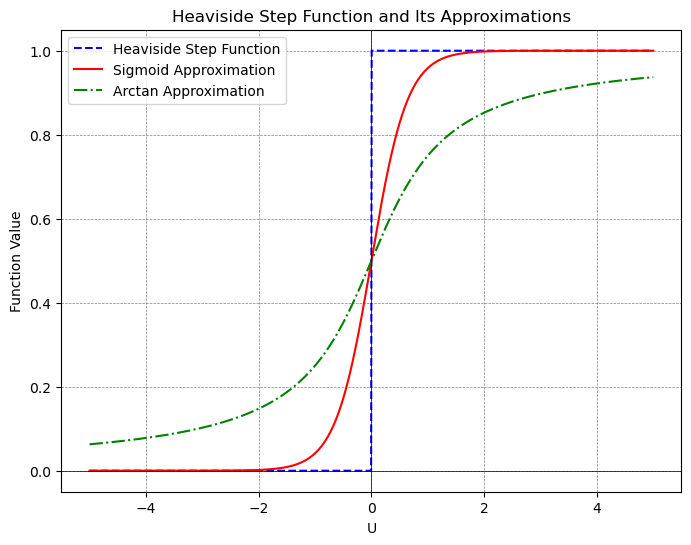

In [6]:
# Define Heaviside step function
def heaviside_step(U):
    return np.where(U >= 0, 1, 0)

# Define sigmoid approximation
def sigmoid_approx(U, beta=np.pi, theta=0):
    return 1 / (1 + np.exp(-beta * (U - theta)))

# Define arctan derivative approximation
def arctan_approx(U, beta=1, theta=0):
    return 0.5 + (1 / np.pi) * np.arctan(beta * (U - theta))

# Generate U values
U_values = np.linspace(-5, 5, 1000)

# Calculate Heaviside step function
heaviside_result = heaviside_step(U_values)

# Calculate sigmoid approximation
sigmoid_result = sigmoid_approx(U_values)

# Calculate arctan approximation
arctan_result = arctan_approx(U_values)

# Plotting
plt.figure(figsize=(8, 6))
plt.plot(U_values, heaviside_result, label='Heaviside Step Function', linestyle='--', color='blue')
plt.plot(U_values, sigmoid_result, label='Sigmoid Approximation', color='red')
plt.plot(U_values, arctan_result, label='Arctan Approximation', linestyle='-.', color='green')

# Adding labels and annotations
plt.title('Heaviside Step Function and Its Approximations')
plt.xlabel('U')
plt.ylabel('Function Value')
plt.axhline(0, color='black', linewidth=0.5)
plt.axvline(0, color='black', linewidth=0.5)
plt.grid(color='gray', linestyle='--', linewidth=0.5)
plt.legend()
plt.show()